### Libraries

In [224]:
import sys
import os
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime, timedelta 
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
import keras

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, LSTM, TimeDistributed, Input
import mlflow
import mlflow.keras


### MLFlow settings

Setup MLflow:

In [225]:
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    experiment_name = "FuelProphet_CCN_Testing-cnn-big_newplot-2"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

mlflow.keras.autolog(log_models=False)

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


# Deep Neural Networks for Time Series Analysis

We can use Deep Neural Networks to analyze time series. There are several options how to do this. 
We can use 
* convolutional neural networks (CNN)
* long-term short memory (LSTM)

or even hybrid models that combine CNN and LSTM layers.

Additionally to the timeseries data that we put in to analyze, we can add features to improve model performance.

### potential features
In the case of gas stations, we can think of the following features that potentially have an effect:
* Day of the week
* Station Type (LKW, Automat, Autobahn, rest stop)
* Oil price
* Exchange Rate
* Location
* Density
* Brand
* Dominant Gas station
* Opening times
* Mean price in radius or city

First, we load the data and clean it a little bit:

# Loading train/test data

In [233]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

# Rename date to datetime

In [234]:
# Train
df01_train.rename(columns={"date": "datetime"}, inplace=True)
df02_train.rename(columns={"date": "datetime"}, inplace=True)
df03_train.rename(columns={"date": "datetime"}, inplace=True)
df04_train.rename(columns={"date": "datetime"}, inplace=True)
df05_train.rename(columns={"date": "datetime"}, inplace=True)
df06_train.rename(columns={"date": "datetime"}, inplace=True)
df07_train.rename(columns={"date": "datetime"}, inplace=True)
df08_train.rename(columns={"date": "datetime"}, inplace=True)
df09_train.rename(columns={"date": "datetime"}, inplace=True)
df10_train.rename(columns={"date": "datetime"}, inplace=True)
df11_train.rename(columns={"date": "datetime"}, inplace=True)
df12_train.rename(columns={"date": "datetime"}, inplace=True)
df13_train.rename(columns={"date": "datetime"}, inplace=True)
df14_train.rename(columns={"date": "datetime"}, inplace=True)
df15_train.rename(columns={"date": "datetime"}, inplace=True)
df16_train.rename(columns={"date": "datetime"}, inplace=True)
df17_train.rename(columns={"date": "datetime"}, inplace=True)
df18_train.rename(columns={"date": "datetime"}, inplace=True)
df19_train.rename(columns={"date": "datetime"}, inplace=True)
df20_train.rename(columns={"date": "datetime"}, inplace=True)
df21_train.rename(columns={"date": "datetime"}, inplace=True)
df22_train.rename(columns={"date": "datetime"}, inplace=True)
df23_train.rename(columns={"date": "datetime"}, inplace=True)
df24_train.rename(columns={"date": "datetime"}, inplace=True)
df25_train.rename(columns={"date": "datetime"}, inplace=True)
df26_train.rename(columns={"date": "datetime"}, inplace=True)
df27_train.rename(columns={"date": "datetime"}, inplace=True)
df28_train.rename(columns={"date": "datetime"}, inplace=True)
df29_train.rename(columns={"date": "datetime"}, inplace=True)
df30_train.rename(columns={"date": "datetime"}, inplace=True)


# Test
df01_test.rename(columns={"date": "datetime"}, inplace=True)
df02_test.rename(columns={"date": "datetime"}, inplace=True) 
df03_test.rename(columns={"date": "datetime"}, inplace=True) 
df04_test.rename(columns={"date": "datetime"}, inplace=True) 
df05_test.rename(columns={"date": "datetime"}, inplace=True) 
df06_test.rename(columns={"date": "datetime"}, inplace=True) 
df07_test.rename(columns={"date": "datetime"}, inplace=True) 
df08_test.rename(columns={"date": "datetime"}, inplace=True) 
df09_test.rename(columns={"date": "datetime"}, inplace=True) 
df10_test.rename(columns={"date": "datetime"}, inplace=True) 
df11_test.rename(columns={"date": "datetime"}, inplace=True) 
df12_test.rename(columns={"date": "datetime"}, inplace=True) 
df13_test.rename(columns={"date": "datetime"}, inplace=True) 
df14_test.rename(columns={"date": "datetime"}, inplace=True) 
df15_test.rename(columns={"date": "datetime"}, inplace=True) 
df16_test.rename(columns={"date": "datetime"}, inplace=True) 
df17_test.rename(columns={"date": "datetime"}, inplace=True) 
df18_test.rename(columns={"date": "datetime"}, inplace=True) 
df19_test.rename(columns={"date": "datetime"}, inplace=True) 
df20_test.rename(columns={"date": "datetime"}, inplace=True) 
df21_test.rename(columns={"date": "datetime"}, inplace=True) 
df22_test.rename(columns={"date": "datetime"}, inplace=True) 
df23_test.rename(columns={"date": "datetime"}, inplace=True) 
df24_test.rename(columns={"date": "datetime"}, inplace=True) 
df25_test.rename(columns={"date": "datetime"}, inplace=True) 
df26_test.rename(columns={"date": "datetime"}, inplace=True) 
df27_test.rename(columns={"date": "datetime"}, inplace=True) 
df28_test.rename(columns={"date": "datetime"}, inplace=True) 
df29_test.rename(columns={"date": "datetime"}, inplace=True) 
df30_test.rename(columns={"date": "datetime"}, inplace=True) 

### Data processing (without feature engineering)

We split the data into train, test and validation:

[-------- Train --------][--- Validation ---][--- Test ---]


It is important to process the data correctly.


1) choose the data of one gas station (using the uuid)
2) define the training data and the test data to avoid data leakage
3) define your sliding window 
4) Create sequences of your train data
5) Create sequences of your test data defining input and output 


### The sliding window to prepare sequential data
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |

# Function Script:

In [ ]:
# def prepare_forecast_data(df_test, scaler,
#                             forecast_output_start,
#                             days_output,
#                             fuel='e5',
#                             window_size=288):
#     """
#     Prepare scaled forecast input data for multi-step forecasting using one column (e.g., 'e5').

#     Parameters:
#     - df: pandas DataFrame with datetime index
#     - scaler: fitted MinMaxScaler
#     - forecast_input_start: datetime, start of input window
#     - forecast_output_start: datetime, start of output window
#     - days_input: number of days for input
#     - days_output: number of days for prediction
#     - fuel: string, name of the column to use (default: 'e5')
#     - window_size: number of steps per day (default: 288 for 5-min data)

#     Returns:
#     - X_forecast: np.array of shape (steps_to_predict, window_size, 1)
#     - y_test: actual values for the forecast period
#     """
#     df = df_test.copy()
    
#     # Get the last window_size points before forecast start
#     input_mask = (df.index < forecast_output_start)
#     initial_window = df[input_mask].iloc[-window_size:][[fuel]]

#         # Scale the window
#     scaled_window = scaler.transform(initial_window)
    
#     # Reshape for model input (1, window_size, 1)
#     X_forecast = scaled_window.reshape(1, window_size, 1)

#     # Get actual values for comparison
#     # y_test = df.loc[
#     #     (df.index >= forecast_output_start) &
#     #     (df.index < forecast_output_start + pd.Timedelta(days=days_output)),
#     #     fuel
#     # ].values.reshape(-1, 1)

#     return X_forecast
####################################################################################################
def create_sequences(
        data, 
        window_size, 
        target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)
##################################################################
def preprocess(
        df_train, df_test,
        fuel='e5',
        output_days=1,
        verbose=True
        ):
    
    # Split data
    # Find the middle point of df_test
    middle_idx = len(df_train) // 2
    
    test_df = df_test
    train_df = df_train[:middle_idx].copy()  # First half
    val_df = df_train[middle_idx:-288].copy()  # Second half
    forecast_df = df_train[-288:].copy()

    # set datetime index
    train_df.set_index('datetime', inplace=True)
    val_df.set_index('datetime', inplace=True)
    test_df.set_index('datetime', inplace=True)
    forecast_df.set_index('datetime', inplace=True)

    # Scaling
    scaler = MinMaxScaler()
    scaler.fit(train_df[[fuel]])

    scaled_train = scaler.transform(train_df[[fuel]])
    scaled_val = scaler.transform(val_df[[fuel]])
    scaled_forecast = scaler.transform(forecast_df[[fuel]])

    # Sequence generation
    window_size = 288
    target_col_index = 0

    X, y = create_sequences(scaled_train, window_size, target_col_index)
    X_val, y_val = create_sequences(scaled_val, window_size, target_col_index)

    # Prepare forecast input (last day's data)
    X_forecast = scaled_forecast.reshape(1, window_size, 1)

    ### === Verbose plots === ###
    if verbose:
        # Time series overview
        plt.figure(figsize=(10,6))
        plt.plot(train_df.index, train_df[fuel], label='Train', drawstyle='steps-post')
        plt.plot(val_df.index, val_df[fuel], label='Validation', drawstyle='steps-post')
        plt.plot(test_df.index, test_df[fuel], label='Test', drawstyle='steps-post')
        plt.title("Train, Validation, and Test Data")
        plt.xlabel("Date")
        plt.ylabel(f"{fuel} Price")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("Data_overview.png")
        mlflow.log_artifact("Data_overview.png")
        plt.show()

        # KDE for distribution comparison
        kde_train = gaussian_kde(train_df[fuel].dropna())
        kde_val = gaussian_kde(val_df[fuel].dropna())
        kde_test = gaussian_kde(test_df[fuel].dropna())

        x_vals = np.linspace(
            min(train_df[fuel].min(), val_df[fuel].min(), test_df[fuel].min()),
            max(train_df[fuel].max(), val_df[fuel].max(), test_df[fuel].max()), 1000
        )

        plt.figure(figsize=(10,4))
        plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
        plt.plot(x_vals, kde_val(x_vals), label='Validation', color='green')
        plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
        plt.title(f"KDE of {fuel} in Train, Validation, Test")
        plt.xlabel(f"{fuel} Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.savefig("KDE.png")
        mlflow.log_artifact("KDE.png")
        plt.show()

        # Log preprocessing parameters
        mlflow.log_params({
                "train_size": len(train_df),
                "val_size": len(val_df),
                "test_size": len(test_df),
                "window_size": window_size,
                "fuel_type": fuel,
                "output_days": output_days
            })

    return X, y, X_val, y_val, X_forecast, scaler, scaled_train, val_df, test_df
###########################
def build_model(model_type, params, input_shape=(288, 1)):
    model = Sequential()
    if model_type == 'cnn_small':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) # 1-dimensional deconvolution
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        ########################################################################
    elif model_type == 'cnn_big':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.2))
        ########################################################################
    elif model_type == 'cnn_lstm_1':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(params['lstm_units'], return_sequences=False))
        ########################################################################
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    return model

###########################

def train_model_with_mlflow(X, y, X_val, y_val, model_type, params, days_output=None, input_shape=(288, 1)):
        # Log parameters manually (optional if autolog is on)
        mlflow.log_param("days_output", days_output)
        mlflow.set_tag("dataset", f'{dataset_name}')
        mlflow.set_tag("model_type", model_type)

        model = build_model(model_type=model_type, params=params, input_shape=input_shape)
        # Train model
        history = model.fit(
            X, y,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=1
        )

        # Log final metrics manually if you want more control
        final_val_loss = history.history['val_loss'][-1]
        mlflow.log_metric("final_val_loss", final_val_loss)

        # Optionally log a plot
        plt.figure()
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='val')
        plt.title("Loss over Epochs")
        plt.legend()
        plt.savefig("loss_plot.png")
        mlflow.log_artifact("loss_plot.png")

        model_path = 'model.keras'
        keras.saving.save_model(model, model_path, save_format="keras")
        mlflow.log_artifact(model_path)

        return model, history
###########################

def inverse_scale(preds, original_data, target_index, scaler):
    """Inverse scale predictions by placing them into a dummy array 
    and applying scaler.inverse_transform."""
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# Function that forecasts and prints the forecast
def forecasting(
        X_forecast,
        scaled_train,
        scaler,
        forecast_start_date=None,
        fuel='e5',
        model = None,
        output_days=7
    ):
    '''
    _summary_

    Args:
        X_forecast (np.array): Output from processing function
        scaled_train (np.array): Output from processing function
        scaler (fitted MinMax Scaler): Output from processing function
        start_forecast (string): date of forecast start already defied in the processing function
        fuel (str, optional): Fuel type, 'es', 'e10' or 'diesel'. Defaults to 'e5'.
    '''
    #window_size = X_forecast.shape[1]  # Should be 288
    steps_per_day = 288  # 5-minute intervals per day
    total_steps = steps_per_day * output_days
    
    # Initialize array for predictions
    predictions = []
    
    # Get initial window
    current_window = X_forecast.copy()  # shape: (1, 288, 1)
    
    # Make recursive predictions
    for step in range(total_steps):
        # Make single prediction
        next_pred = model.predict(current_window, verbose=0)[0, 0]
        predictions.append(next_pred)
        
        # Update window by removing oldest value and adding prediction
        current_window = np.roll(current_window, -1, axis=1)
        current_window[0, -1, 0] = next_pred
    
    # Convert predictions to array and reshape
    predictions = np.array(predictions).reshape(-1, 1)
    
    # Scale back to original range
    predictions_unscaled = inverse_scale(predictions, scaled_train, target_index=0, scaler=scaler)
    
    # Create datetime index for the forecast period
    time_index = pd.date_range(
        start=forecast_start_date,
        periods=total_steps,
        freq='5min'
    )
    
    # Return as DataFrame
    return pd.DataFrame({
        'datetime': time_index,
        'e5': predictions_unscaled.flatten()
    })

# Function to plot
def plot_forecast(df_train, df_test, station_uuid=None, df_train_prediction=None, 
                 df_test_prediction=None, train_dates=None, test_dates=None, 
                 train_dates_plot=None, test_dates_plot=None):
    
    plt.figure(figsize=(15, 6))
    
    # Convert string dates to timestamps if they aren't already
    if train_dates and isinstance(train_dates[0], str):
        train_dates = (pd.to_datetime(train_dates[0]), pd.to_datetime(train_dates[1]))
    if test_dates and isinstance(test_dates[0], str):
        test_dates = (pd.to_datetime(test_dates[0]), pd.to_datetime(test_dates[1]))

    train_mask = (df_train['datetime'] >= train_dates[0]) & (df_train['datetime'] <= train_dates[1]) if train_dates else slice(None)
    test_mask = (df_test['datetime'] >= test_dates[0]) & (df_test['datetime'] <= test_dates[1]) if test_dates else slice(None)
    
    if station_uuid is not None:
        df_train = df_train[df_train['station_uuid'] == station_uuid]
        df_test = df_test[df_test['station_uuid'] == station_uuid]

    if df_train_prediction is not None:
        df_train_prediction = df_train_prediction[(df_train_prediction['datetime'] >= train_dates[0]) & (df_train_prediction['datetime'] <= train_dates[1])]
        plt.plot(df_train_prediction['datetime'], df_train_prediction['e5'], label='Train Prediction', color='green', linestyle='--', linewidth=2, drawstyle='steps-post')

    if df_test_prediction is not None:
        df_test_prediction = df_test_prediction[(df_test_prediction['datetime'] >= test_dates[0]) & (df_test_prediction['datetime'] <= test_dates[1])]
        plt.plot(df_test_prediction['datetime'], df_test_prediction['e5'], label='Test Prediction', color='red', linestyle='--', linewidth=2, drawstyle='steps-post')

        # --- Error Calculation and Display ---
        df_merged = df_test.merge(df_test_prediction, on='datetime', suffixes=('_actual', '_pred'))
        df_merged = df_merged.sort_values('datetime').reset_index(drop=True)

        mae_dict = {}
        rmse_dict = {}
        r2_dict = {}

        for i, days in enumerate([1, 3, 7]):
            time_cutoff = df_merged['datetime'].min() + timedelta(days=days)
            df_subset = df_merged[df_merged['datetime'] < time_cutoff]

            if not df_subset.empty:
                mae = mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred'])
                rmse = np.sqrt(mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred']))
                r2 = r2_score(df_subset['e5_actual'], df_subset['e5_pred'])
                mae_dict[days] = mae
                rmse_dict[days] = rmse
                r2_dict[days] = r2

                print(f"{days}-Day MAE in cent: {mae *100:.4f}")
                print(f"{days}-Day RMSE in cent: {rmse *100:.4f}")
                print(f"{days}-Day r2-score: {r2:.4f}")
                #plt.text(0.01, 0.95 - 0.05 * i, f'{days}-day MAE in cent: {mae*100:.4f}', 
                         #transform=plt.gca().transAxes, fontsize=12, 
                         #bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7))
    
    plt.plot(df_train.loc[train_mask, 'datetime'], df_train.loc[train_mask, 'e5'], label='Train Actual', color='blue', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.plot(df_test.loc[test_mask, 'datetime'], df_test.loc[test_mask, 'e5'], label='Test Actual', color='orange', linewidth=2, drawstyle='steps-post', alpha=0.7)
    
    plt.legend(fontsize=12, title_fontsize=14, loc='best', frameon=True, fancybox=True, shadow=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('E5 Price: Actual vs Prediction', fontsize=16)
    plt.xlabel('date', fontsize=14)
    plt.ylabel('E5 price', fontsize=14)
    plt.tight_layout(pad=2)
    plt.gca().set_facecolor('#f7f7fa')
    plt.gcf().patch.set_facecolor('#eaeaf2')
    plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7)
    plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7)
    plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))
    plt.savefig("prediction.png")
    plt.show()

    # After the loop, you have:
    mae_1_day = mae_dict.get(1)
    mae_3_day = mae_dict.get(3)
    mae_7_day = mae_dict.get(7)

    rmse_1_day = rmse_dict.get(1)
    rmse_3_day = rmse_dict.get(3)
    rmse_7_day = rmse_dict.get(7)

    r2_1_day = r2_dict.get(1)
    r2_3_day = r2_dict.get(3)
    r2_7_day = r2_dict.get(7)

    return mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day


# Start of the analysis

In [236]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}

In [68]:
# forecast_freq = 5 # minutes, discretization between individual values of the forecast
# forecast_days = 7 # how many days should be forecasted
# train_days = 30 # how many days will be used to train on
# sampling_rate = 5 #in minutes, very important parameter


# # Create an error log dictionary
# error_log = {}

# # LOOP
# for dataset_name, (df_train, df_test) in datasets.items():
#     print(f"\nProcessing dataset: {dataset_name}")
    
#     try:
#         mlflow.end_run()
        
#         with mlflow.start_run(run_name=f"fuel_model_CNN_LSTM-{dataset_name}") as run:
#             mlflow.set_tag("dataset", f'{dataset_name}')
#             output_days = 7 
#             fuel='e5' 

#             train_start = pd.to_datetime(df_train['datetime'].iloc[-1]) - pd.Timedelta(days = train_days)
#             train_end = pd.to_datetime(df_train['datetime'].iloc[-1])
#             # The forecast starts immediately after the training data ends
#             forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
#             # The forecast extends for 'forecast_days' from its start
#             forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)

#             # PREPROCESSING
#             X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df = preprocess(
#                     df_train=df_train, 
#                     df_test=df_test,
#                     verbose=False
#             )
# # MODEL SETTING HERE:
#             # MODELING
#             params = {
#                 'epochs': 1,
#                 'batch_size': 32,
#                 'lstm_units': 50
#             }

#             model_type = 'cnn_small' # choose between: 'ccn_small', 'ccn_big' and 'cnn_lstm_1'
            
#             trained_model, history = train_model_with_mlflow(
#                 X=X, 
#                 y=y, 
#                 X_val=X_val, 
#                 y_val=y_val,
#                 model_type=model_type,
#                 params=params
#             )
        
#             train_start = pd.to_datetime(df_train['datetime'].iloc[-1]) - pd.Timedelta(days = train_days)
#             train_end = pd.to_datetime(df_train['datetime'].iloc[-1])
#             # The forecast starts immediately after the training data ends
#             forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
#             # The forecast extends for 'forecast_days' from its start
#             forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)
#             train_plot_start = pd.to_datetime(df_train['datetime'].iloc[-1]) - pd.Timedelta(days = 2)
#             train_plot_end = pd.to_datetime(df_train['datetime'].iloc[-1]) + pd.Timedelta(days = 1)

#             train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
#             test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), forecast_end_date.strftime('%Y-%m-%d'))

#             # FORECASTING
#             y_pred_df = forecasting(X_forecast, scaled_train, scaler, fuel='e5', model = trained_model)

#             # Plot
#             mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day = plot_forecast(
#                 df_train=df_train,
#                 df_test=df_test,
#                 station_uuid=None,
#                 df_train_prediction=None,
#                 df_test_prediction=y_pred_df,
#                 train_dates=train_dates_plot,
#                 test_dates=test_dates_plot,
#                 train_dates_plot=train_dates_plot,
#                 test_dates_plot=test_dates_plot
#             )
#             mlflow.log_artifact("prediction.png")
#             mlflow.log_metrics({
#             "mae_1_day": mae_1_day,
#             "mae_3_day": mae_3_day,
#             "mae_7_day": mae_7_day,
#             "rmse_1_day": rmse_1_day,
#             "rmse_3_day": rmse_3_day,
#             "rmse_7_day": rmse_7_day,
#             "r2_1_day": r2_1_day,
#             "r2_3_day": r2_3_day,
#             "r2_7_day": r2_7_day
#             })

#         print(f"Successfully processed {dataset_name}")
        
#     except Exception as e:
#         # Log the error and continue with next dataset
#         error_message = f"Error in {dataset_name}: {str(e)}"
#         error_log[dataset_name] = error_message
#         print(error_message)
        
#         # Make sure to end the MLflow run if it failed
#         mlflow.end_run()
#         continue

# # After the loop, print summary of errors
# print("\n=== Error Summary ===")
# if error_log:
#     print(f"Total errors: {len(error_log)}")
#     for dataset, error in error_log.items():
#         print(f"\n{dataset}:")
#         print(error)
# else:
#     print("All datasets processed successfully!")


Processing dataset: df01


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.3679 - val_loss: 0.1538
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0124 - val_loss: 0.0606
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0084 - val_loss: 0.0160
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0072 - val_loss: 0.0135
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0064 - val_loss: 0.0160
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0052 - val_loss: 0.0065
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0045 - val_loss: 0.0088
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10

1-Day MAE in cent: 3.4705
1-Day RMSE in cent: 18.6294
1-Day r2-score: -1.9779
3-Day MAE in cent: 10.8580
3-Day RMSE in cent: 32.9515
3-Day r2-score: -30.6572
7-Day MAE in cent: 17.6835
7-Day RMSE in cent: 42.0517
7-Day r2-score: -60.0249


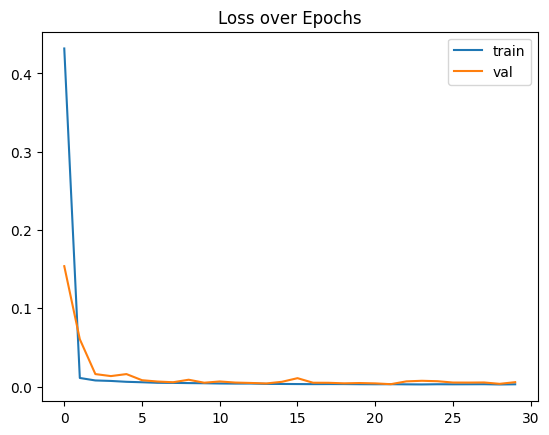

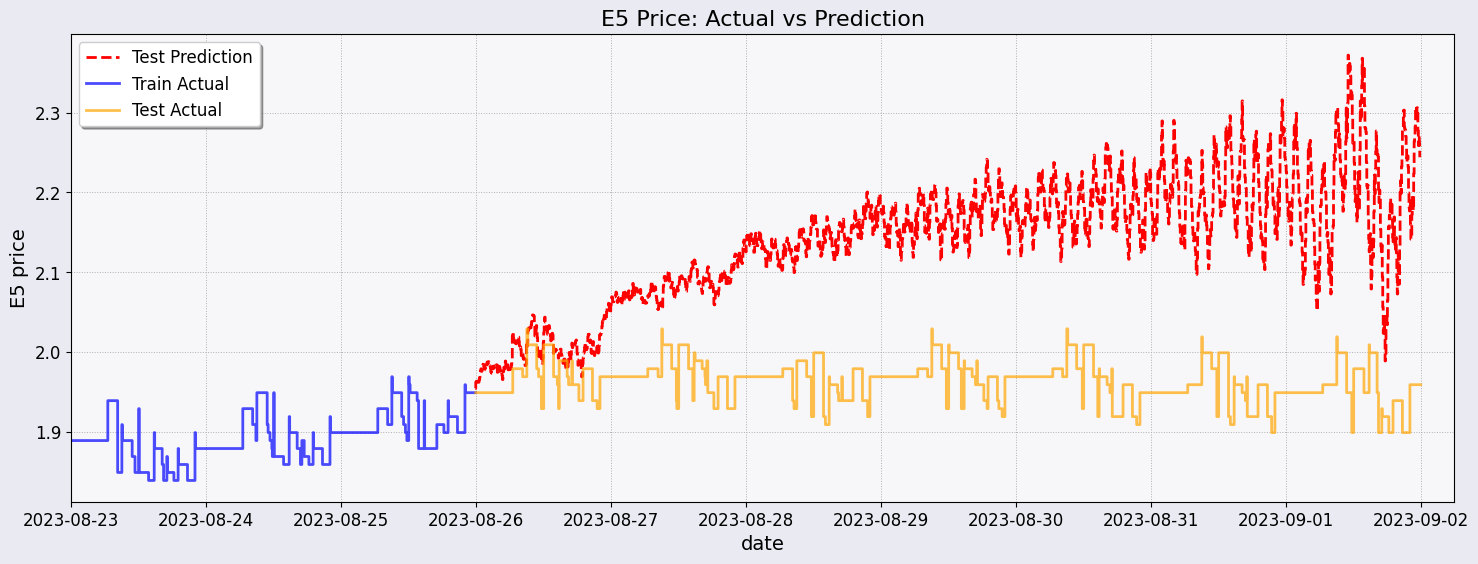

Successfully processed df01

Processing dataset: df02


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.1796 - val_loss: 0.0391
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0121 - val_loss: 0.0249
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0092 - val_loss: 0.0079
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0053 - val_loss: 0.0066
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3

ValueError: Input contains infinity or a value too large for dtype('float64').

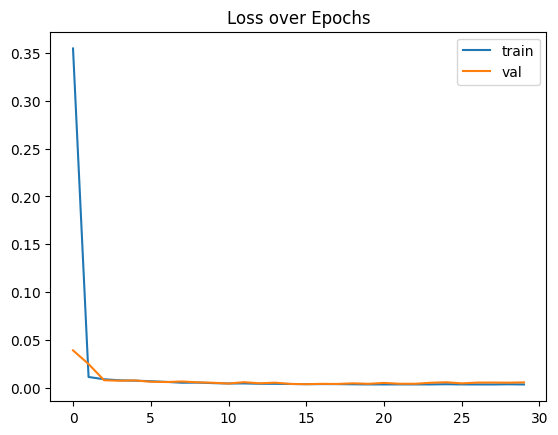

In [ ]:
forecast_freq = 5 # minutes, discretization between individual values of the forecast
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter




# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    mlflow.end_run()
    
    with mlflow.start_run(run_name=f"fuel_model_cnn-{dataset_name}") as run:
        mlflow.set_tag("dataset", f'{dataset_name}')
        output_days = 7 
        fuel='e5' 
        train_start = pd.to_datetime(df_train['datetime'].iloc[-1]) - pd.Timedelta(days = train_days)
        train_end = pd.to_datetime(df_train['datetime'].iloc[-1])
        # The forecast starts immediately after the training data ends
        forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
        # The forecast extends for 'forecast_days' from its start
        forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)
        
        # PREPROCESSING
        X, y, X_val, y_val, X_forecast, scaler, scaled_train, val_df, test_df = preprocess(
                df_train=df_train, 
                df_test=df_test,
                verbose=False
        )
        
        # MODELING
        params = {
            'epochs': 30,
            'batch_size': 32,
            'lstm_units': 50
        }
        model_type = 'cnn_big' # choose between: 'cnn_small', 'cnn_big' and 'cnn_lstm_1'
        
        trained_model, history = train_model_with_mlflow(
            X=X, 
            y=y, 
            X_val=X_val, 
            y_val=y_val,
            model_type=model_type,
            params=params
        )
        val_df_plot = val_df.reset_index()
        train_start = pd.to_datetime(df_train['datetime'].iloc[-1]) - pd.Timedelta(days = train_days)
        val_end = pd.to_datetime(val_df_plot['datetime'].iloc[-1])
        # The forecast starts immediately after the training data ends
        forecast_start_date = val_end + pd.Timedelta(days=1)
        # The forecast extends for 'forecast_days' from its start
        forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)
        train_plot_start = pd.to_datetime(df_train['datetime'].iloc[-1]) - pd.Timedelta(days = 2)
        train_plot_end = pd.to_datetime(df_train['datetime'].iloc[-1]) + pd.Timedelta(days = 1)
        train_dates_plot = (pd.to_datetime(train_plot_start.strftime('%Y-%m-%d')), pd.to_datetime(train_plot_end.strftime('%Y-%m-%d')))
        test_dates_plot = pd.to_datetime(forecast_start_date.strftime('%Y-%m-%d')), pd.to_datetime(forecast_end_date.strftime('%Y-%m-%d'))+ pd.Timedelta(days = 1.25)

        # FORECASTING
        y_pred_df = forecasting(X_forecast, scaled_train, scaler, fuel='e5', model = trained_model, output_days=output_days, forecast_start_date=forecast_start_date)

        # reset index before plotting
        df_train_plot = df_train.reset_index()
        df_test_plot = df_test.reset_index()
        y_pred_df_plot = y_pred_df.reset_index()
        
        # Plot
        mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day = plot_forecast(
            df_train=df_train_plot,
            df_test=df_test_plot,
            station_uuid=None,
            df_train_prediction=None,
            df_test_prediction=y_pred_df_plot,
            train_dates=train_dates_plot,
            test_dates=test_dates_plot,
            train_dates_plot=train_dates_plot,
            test_dates_plot=test_dates_plot
        )
        mlflow.log_artifact("prediction.png")
        mlflow.log_metrics({
        "mae_1_day": mae_1_day,
        "mae_3_day": mae_3_day,
        "mae_7_day": mae_7_day,
        "rmse_1_day": rmse_1_day,
        "rmse_3_day": rmse_3_day,
        "rmse_7_day": rmse_7_day,
        "r2_1_day": r2_1_day,
        "r2_3_day": r2_3_day,
        "r2_7_day": r2_7_day
        })
    print(f"Successfully processed {dataset_name}")

=== Error Summary ===
Total errors: 2

df06:
Error in df06: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (288,) + inhomogeneous part.

df20:
Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

In [ ]:
mlflow.end_run()

# Checking your data with MLFlow:
Start the MLFlow by entering "mlflow ui" into the Terminal and opening the given uri in your browser.
To abort MLflow again, go to terminal and press "ctrl+c".

In [ ]:
%mlflow ui --backend-store-uri file:data/mlflow

UsageError: Line magic function `%mlflow` not found.
